In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/omega')
from keras.layers import Input, Reshape, LSTM, RepeatVector, TimeDistributed
from keras.models import Model
from keras import callbacks
import datetime
from scipy import linalg, dot

In [40]:
sample_data = pd.read_csv('sample_simulated_transaction_history.csv')

In [41]:
pd.set_option('display.max_columns', None)

In [42]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [43]:
sample_data.shape

(939512, 11)

In [44]:
sample_data.date = pd.to_datetime(sample_data.date)

In [45]:
def name_trunc(x):
    x = "_".join(x.split("_", 2)[:2])
    return x

In [46]:
sample_data.id = sample_data.id.map(lambda x:name_trunc(x))

In [47]:
df = []
depts = []
for i in sample_data.dept.unique():
    df.append(sample_data[(sample_data.dept == i)].reset_index(drop = True)[['id','date', 'purchaseamount']])
    depts.append(i)

In [48]:
sample_data.isnull().values.any()

False

In [49]:
def obtain_encoding(dataframe, depts, sample_data, pre_end_date, pre_start_date, EPOCHS, BATCH_SIZE, DIM):
    complete_data = pd.DataFrame({'date':pd.date_range(sample_data.date.min(), sample_data.date.max())})
    complete_data.set_index('date', inplace = True)
    for i in dataframe.id.unique():
        specific_donor = dataframe[(dataframe.id == i)].reset_index(drop = True).groupby(['date']).max().drop(labels = ['id'], axis = 1).reindex(pd.date_range(sample_data.date.min(), sample_data.date.max()), fill_value = 0)
        complete_data[i] = pd.DataFrame({i:specific_donor.purchaseamount})

    xtrain = complete_data[pre_start_date:pre_end_date]
    x_train = xtrain.T.values
    xtrain1 = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    encoding_dim = DIM

    inputs = Input(shape=(xtrain1.shape[1],1))
    encoded = LSTM(encoding_dim)(inputs)

    decoded1 = Reshape((encoding_dim,1))(encoded)
    decoded = LSTM(xtrain1.shape[1])(decoded1)
    decoded = Reshape((xtrain1.shape[1],1))(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    sequence_autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
    history = sequence_autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=5, mode='auto')])

    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.savefig('performance-%s.png' % depts)

    encoded_mat = encoder.predict(xtrain1)
    new_df = pd.DataFrame(encoded_mat)
    new_df[new_df<0] = 0
    new_df.insert(loc=0, column='id', value=complete_data.columns.values)

    original = pd.DataFrame(x_train)
    original.insert(loc = 0, column = 'id', value = complete_data.columns.values)

    decoded_mat = sequence_autoencoder.predict(xtrain1)
    decoded_mat = np.reshape(decoded_mat, (decoded_mat.shape[0], decoded_mat.shape[1]))
    comparison_df = pd.DataFrame(decoded_mat)
    comparison_df[comparison_df<0] = 0
    comparison_df.insert(loc = 0, column = 'id', value = complete_data.columns.values)
    
    score = dot(x_train,decoded_mat.T)/linalg.norm(x_train)/linalg.norm(decoded_mat)
    
    return new_df, original, comparison_df, np.linalg.norm(score, ord = 2)

Epoch 1/500
2617/2617 [==============================] - 31s 12ms/step - loss: 451.8359 - mean_absolute_error: 1.2688
Epoch 2/500
2617/2617 [==============================] - 36s 14ms/step - loss: 451.5694 - mean_absolute_error: 1.4284
Epoch 3/500
2617/2617 [==============================] - 43s 16ms/step - loss: 450.8543 - mean_absolute_error: 1.8539
Epoch 4/500
2617/2617 [==============================] - 38s 15ms/step - loss: 450.5399 - mean_absolute_error: 2.0462
Epoch 5/500
2617/2617 [==============================] - 37s 14ms/step - loss: 450.4415 - mean_absolute_error: 2.1074
Epoch 6/500
2617/2617 [==============================] - 39s 15ms/step - loss: 450.4194 - mean_absolute_error: 2.1181
Epoch 7/500
2617/2617 [==============================] - 38s 15ms/step - loss: 450.4014 - mean_absolute_error: 2.1242
Epoch 8/500
2617/2617 [==============================] - 43s 16ms/step - loss: 450.3916 - mean_absolute_error: 2.1257
Epoch 9/500
2617/2617 [==============================] -

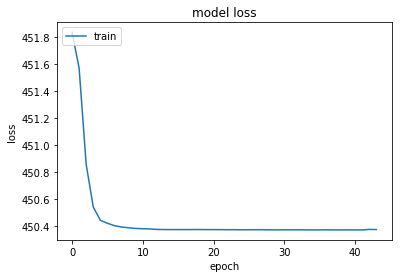

Epoch 1/500
2617/2617 [==============================] - 31s 12ms/step - loss: 3745.2346 - mean_absolute_error: 11.9770
Epoch 2/500
2617/2617 [==============================] - 28s 11ms/step - loss: 3735.3043 - mean_absolute_error: 12.3963
Epoch 3/500
2617/2617 [==============================] - 29s 11ms/step - loss: 3726.2136 - mean_absolute_error: 12.7156
Epoch 4/500
2617/2617 [==============================] - 29s 11ms/step - loss: 3724.2962 - mean_absolute_error: 12.7596
Epoch 5/500
2617/2617 [==============================] - 29s 11ms/step - loss: 3724.0275 - mean_absolute_error: 12.7602
Epoch 6/500
2617/2617 [==============================] - 28s 11ms/step - loss: 3723.9999 - mean_absolute_error: 12.7611
Epoch 7/500
2617/2617 [==============================] - 29s 11ms/step - loss: 3723.9999 - mean_absolute_error: 12.7611
Epoch 8/500
2617/2617 [==============================] - 29s 11ms/step - loss: 3724.0000 - mean_absolute_error: 12.7611
Epoch 9/500
2617/2617 [=================

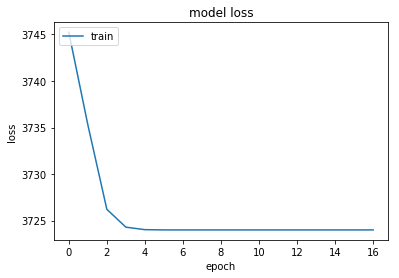

Epoch 1/500
2617/2617 [==============================] - 31s 12ms/step - loss: 45.0467 - mean_absolute_error: 1.6857
Epoch 2/500
2617/2617 [==============================] - 29s 11ms/step - loss: 43.9885 - mean_absolute_error: 2.0425
Epoch 3/500
2617/2617 [==============================] - 29s 11ms/step - loss: 43.0874 - mean_absolute_error: 2.3826
Epoch 4/500
2617/2617 [==============================] - 29s 11ms/step - loss: 42.8598 - mean_absolute_error: 2.4694
Epoch 5/500
2617/2617 [==============================] - 28s 11ms/step - loss: 42.8434 - mean_absolute_error: 2.4754
Epoch 6/500
2617/2617 [==============================] - 28s 11ms/step - loss: 42.8365 - mean_absolute_error: 2.4780
Epoch 7/500
2617/2617 [==============================] - 29s 11ms/step - loss: 42.8340 - mean_absolute_error: 2.4793
Epoch 8/500
2617/2617 [==============================] - 28s 11ms/step - loss: 42.8338 - mean_absolute_error: 2.4794
Epoch 9/500
2617/2617 [==============================] - 29s 11m

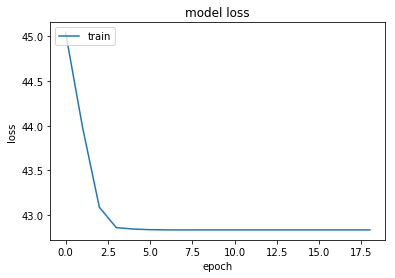

Epoch 1/500
2617/2617 [==============================] - 32s 12ms/step - loss: 21.8896 - mean_absolute_error: 0.3787
Epoch 2/500
2617/2617 [==============================] - 28s 11ms/step - loss: 21.8284 - mean_absolute_error: 0.5818
Epoch 3/500
2617/2617 [==============================] - 28s 11ms/step - loss: 21.7586 - mean_absolute_error: 0.7088
Epoch 4/500
2617/2617 [==============================] - 29s 11ms/step - loss: 21.7503 - mean_absolute_error: 0.7106
Epoch 5/500
2617/2617 [==============================] - 29s 11ms/step - loss: 21.7480 - mean_absolute_error: 0.7090
Epoch 6/500
2617/2617 [==============================] - 29s 11ms/step - loss: 21.7466 - mean_absolute_error: 0.7246
Epoch 7/500
2617/2617 [==============================] - 28s 11ms/step - loss: 21.7455 - mean_absolute_error: 0.7346
Epoch 8/500
2617/2617 [==============================] - 28s 11ms/step - loss: 21.7452 - mean_absolute_error: 0.7294
Epoch 9/500
2617/2617 [==============================] - 30s 11m

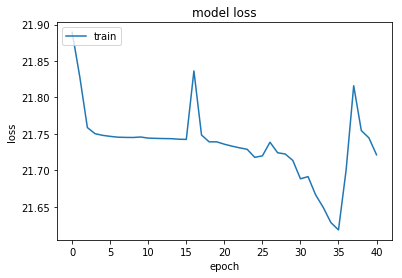

Epoch 1/500
2617/2617 [==============================] - 32s 12ms/step - loss: 124.8057 - mean_absolute_error: 0.8771
Epoch 2/500
2617/2617 [==============================] - 28s 11ms/step - loss: 124.5421 - mean_absolute_error: 1.1043
Epoch 3/500
2617/2617 [==============================] - 28s 11ms/step - loss: 124.2065 - mean_absolute_error: 1.4650
Epoch 4/500
2617/2617 [==============================] - 29s 11ms/step - loss: 124.1051 - mean_absolute_error: 1.6033
Epoch 5/500
2617/2617 [==============================] - 28s 11ms/step - loss: 124.0804 - mean_absolute_error: 1.6789
Epoch 6/500
2617/2617 [==============================] - 29s 11ms/step - loss: 124.0777 - mean_absolute_error: 1.6915
Epoch 7/500
2617/2617 [==============================] - 29s 11ms/step - loss: 124.0733 - mean_absolute_error: 1.6685
Epoch 8/500
2617/2617 [==============================] - 28s 11ms/step - loss: 124.0686 - mean_absolute_error: 1.6481
Epoch 9/500
2617/2617 [==============================] -

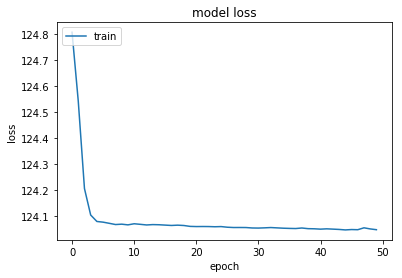

Epoch 1/500
2617/2617 [==============================] - 32s 12ms/step - loss: 1952.5353 - mean_absolute_error: 4.3579
Epoch 2/500
2617/2617 [==============================] - 29s 11ms/step - loss: 1949.7841 - mean_absolute_error: 4.7371
Epoch 3/500
2617/2617 [==============================] - 28s 11ms/step - loss: 1946.3495 - mean_absolute_error: 5.0985
Epoch 4/500
2617/2617 [==============================] - 28s 11ms/step - loss: 1945.4953 - mean_absolute_error: 5.1831
Epoch 5/500
2617/2617 [==============================] - 28s 11ms/step - loss: 1945.4463 - mean_absolute_error: 5.1863
Epoch 6/500
2617/2617 [==============================] - 29s 11ms/step - loss: 1945.4391 - mean_absolute_error: 5.1874
Epoch 7/500
2617/2617 [==============================] - 28s 11ms/step - loss: 1945.4391 - mean_absolute_error: 5.1874
Epoch 8/500
2617/2617 [==============================] - 28s 11ms/step - loss: 1945.4391 - mean_absolute_error: 5.1874
Epoch 9/500
2617/2617 [=========================

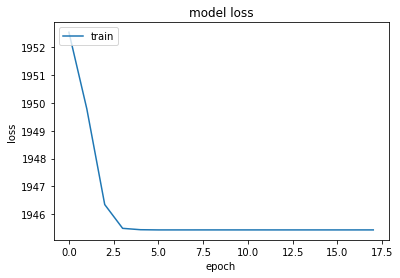

In [50]:
encod = []
original = []
compare = []
score = []
pre_start_date = '2015-01-01'
pre_end_date = '2016-01-01'
for i in range(len(df)):
    alpha, beta, gamma, delta = obtain_encoding(df[i], depts[i], sample_data, pre_end_date, pre_start_date, EPOCHS=500, BATCH_SIZE=500, DIM=50)
    encod.append(alpha)
    original.append(beta)
    compare.append(gamma)
    score.append(delta)
    encod[-1].to_csv('encoding_of_%s_customers.csv' %depts[i], index = False)
    original[-1].to_csv('original_of_%s_customers.csv' %depts[i], index = False)
    compare[-1].to_csv('comparison_of_%s_customers.csv' %depts[i], index = False)

In [51]:
print('Mean cosine distance:', np.mean(score))

Mean cosine distance: 0.49752056432019337
